# 前言

打算详细深入了解bert和transform的原理和源代码，之前已经读完了“基于attention的seq2seq机器翻译”源代码，这篇是Transformer，代码来自tf2.0官网demo，个人修正了一部分bug，可以跑通，并做了更详尽的注释。

# 备注

西班牙语-英语的翻译，自己换个训练文件也能跑通

参考自官方demo，网址https://www.tensorflow.org/tutorials/text/nmt_with_attention

原代码有部分bug，已修正，保证跑通

注释更详尽，已尽力做到傻瓜式

官网有更多的结构图和数学理论，看不懂的可以结合官网理解

# 代码

In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"   
# 本地调试我用的核显本，无cuda，故屏蔽GPU，实际上不加这么一句也无所谓，因为检测不到GPU的话就自动调用cpu了，主要还是为了调试方便，比如有时候你显存不够用，就只能先屏蔽GPU了
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import io
import time
# if gpus:
#     try:    
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# #设置增长式显存占用

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
                               with_info=True,
                               as_supervised=True)
#api手册里，这个tfds.load讲了一大堆，实际业务中估计也不会用这个函数提供的数据，有兴趣的可以看看手册
#从手册里找到这么一句：Loads the named dataset into a `tf.data.Dataset`，
#就是将指定的数据集下载下来(DataSet格式)，大概理解就行

In [4]:
train_examples, val_examples = examples['train'], examples['validation']
#这个train_examples是个PrefetchDataset，但是之前的tfds.load函数手册里并没有提到这点，不知为何
#虽然并不影响阅读代码，但是不用迭代器看不了数据，显示为None
#关于PrefetchDataset的解释，后面有，现在把他当普通Dataset理解就行

In [5]:
train_examples

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [7]:
tokenizer_en = \
tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() 
                                                           for pt, en 
                                                           in train_examples), 
                                                          target_vocab_size=2**13)
#原文是tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
#但是总提示features下没有text这个方法，后来查tf官网，才知道text方法已经被弃用，挪到deprecated下了
#功能就是把文本变成编码，同时也提供解码功能，下面的几行示例很好的展示了作用
#类似功能的函数很多，keras下也有替代品，根据情况自己写也行；无需理解，反正也被弃用了
tokenizer_pt = \
tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() 
                                                           for pt, en 
                                                           in train_examples), 
                                                          target_vocab_size=2**13)

In [8]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))
#输出：Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
#很明显，编码后维度超出了原文长度，因为如果单词不在词典中，
#分词器会把单词分解为子词来对字符串进行编码
#后面会有示例

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))
# 输出：The original string: Transformer is awesome.

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [9]:
for ts in tokenized_string:
 print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))
# 输出：
#7915 ----> T
#1248 ----> ran
#7946 ----> s
#7194 ----> former 
#13 ----> is 
#2799 ----> awesome
#7877 ----> .

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [10]:
#一些参数
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40  #为了使本示例较小且相对较快，删除长度大于40个标记的样本

In [11]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    # [葡萄牙语词汇量]+lang1所有词汇编码后的列表+[葡萄牙语词汇量+1]，这三个列表合并
    # 本例中，葡萄牙语词汇量是8214，后续处理文本的时候，8214当做起始符，8215当做终止符
    # 实际业务中按照自己的习惯处理就行，比如：
    # 在句子首位分别加上<start>和<end>，然后整个语料库一起扔进tf.keras.preprocessing.text.Tokenizer模块里编码

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
    # 英语，处理逻辑同上
  
    return lang1, lang2

In [12]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,tf.size(y) <= max_length)
# 这个tf.logical_and就是 逻辑与 的功能
# 因为训练的时候用了个tf.function装饰器，tf就使用静态图计算
# 我在https://blog.csdn.net/ziyi9663/article/details/109989814这篇文章里也提到过
# 这样做可以加速计算，但是对tensor值的一些操作就不能直接进行了

关于这个tf_encode()函数中tf.py_function()方法，源代码的注释是： .map() 内部的操作以图模式（graph mode）运行，.map() 接收一个不具有 numpy 属性的图张量（graph tensor）。该分词器（tokenizer）需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 tf.py_function 内部运行编码过程，tf.py_function 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。

上面这段说得有点复杂，重新查了下tf.py_function的api手册，api手册是这么说的：Wraps a python function into a TensorFlow op that executes it eagerly.说人话，还是关于静态图和动态图的那一套，为了计算速度用了静态图，中途要对张量做处理，就得用点别的办法。

In [13]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    # 用tf.py_function包裹encode函数
    
    result_pt.set_shape([None])
    # 句子维度设置为None，避免定长带来问题，不理解的话可以先跳过set shape这个方法往下看，不影响理解代码
    result_en.set_shape([None])
    
    return result_pt, result_en

In [14]:
train_dataset = train_examples.map(tf_encode)
#这里的map，对train_examples的每个元素，使用tf_encode方法
#train_examples一个元素就是一个葡萄牙语-英语句子对，两个变量，对应tf_encode两个参数
#然后这俩参数传给被tf_encode包裹的encode函数

In [15]:
train_dataset = train_dataset.filter(filter_max_length)
#dataset的filter方法，感觉就是Python的filter函数的精简版，官方doc太长不看：
#就是传个函数，这个函数对数据集的每条数据做处理，返回True的数据就保留
#本例中，就是葡萄牙语句子和英语句子长度都不大于MAX_LENGTH(就是40)的训练数据(一条数据是葡语和英语句子对)才得以保留
#有兴趣的可以查看官方手册，但其实filter方法就这么一个参数，也没啥高级功能可看的

In [16]:
train_dataset = train_dataset.cache()
#将数据集缓存到内存中以加快读取速度。

In [17]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
#这个padded_batch就是结合了padding和batch的操作，有个padded_shapes参数(这里没传参)，默认[-1]，就是按照最大长度进行padding
#前面虽然用filter函数筛选了，但是长度不足的还得补0
#刚开始还在想为什么不跳过filter步骤，直接在这里传个[40]进去，然后很快就想明白了，这是翻译，把超出长度的句子砍个尾巴，那翻译出来肯定有问题
#文本分类有时候可能不在意，可以尝试直接padding

In [18]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
#关于prefetch方法：
#提前加载数据并用cpu处理，避免传统流程：cpu处理一个batch的数据——GPU计算——cpu处理一个batch的数据——GPU计算。。。如此循环
#避免GPU在等cpu，加快速度
#预加载量可以自己设定，一般大于batch size才有意义，
#这里设置的是tf.data.experimental.AUTOTUNE，就是让tf根据gpu计算速度动态调整

In [19]:
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)
#验证集，一个处理方法，也没必要用prefetch方法

In [20]:
pt_batch, en_batch = next(iter(val_dataset))
# 一开始就说过，不用迭代器看不了数据
print(pt_batch, en_batch)
# 输出：
# tf.Tensor(
# [[8214  342 3032 ...    0    0    0]
#  [8214   95  198 ...    0    0    0]
#  [8214 4479 7990 ...    0    0    0]
#  ...
#  [8214  584   12 ...    0    0    0]
#  [8214   59 1548 ...    0    0    0]
#  [8214  118   34 ...    0    0    0]], shape=(64, 38), dtype=int64) tf.Tensor(
# [[8087   98   25 ...    0    0    0]
#  [8087   12   20 ...    0    0    0]
#  [8087   12 5453 ...    0    0    0]
#  ...
#  [8087   18 2059 ...    0    0    0]
#  [8087   16 1436 ...    0    0    0]
#  [8087   15   57 ...    0    0    0]], shape=(64, 40), dtype=int64)

tf.Tensor(
[[8214  342 3032 ...    0    0    0]
 [8214   95  198 ...    0    0    0]
 [8214 4479 7990 ...    0    0    0]
 ...
 [8214  584   12 ...    0    0    0]
 [8214   59 1548 ...    0    0    0]
 [8214  118   34 ...    0    0    0]], shape=(64, 38), dtype=int64) tf.Tensor(
[[8087   98   25 ...    0    0    0]
 [8087   12   20 ...    0    0    0]
 [8087   12 5453 ...    0    0    0]
 ...
 [8087   18 2059 ...    0    0    0]
 [8087   16 1436 ...    0    0    0]
 [8087   15   57 ...    0    0    0]], shape=(64, 40), dtype=int64)


# 位置编码

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于它们含义的相似度以及它们在句子中的位置，在 d 维空间中离彼此更近。

In [21]:
def get_angles(pos, i, d_model):
    """就是计算公式里sin和cos括号里的，参数类型是我根据下面的代码推测的，方便理解本函数
    Args:
        pos: ndarray型
        i: 也是ndarray型
        d_model: int型
    Returns:
        计算公式里sin和cos括号里的部分
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    # 以后面的调用为例，传入的pos是维度(50,1)的ndarray，i是维度(1,512)的ndarray，d_model是整型512
    # 于是angle_rates也是(1,512)的ndarray
     
    return pos * angle_rates
    # 于是返回值pos * angle_rates的维度就是(50,512)
    # 从这里也可以看到，位置编码是根据position的值一下子把整个序列的每一时间步的编码都算出来的
    # 实际用的时候，根据序列长度，对位置编码切片取值

关于下面函数所用的部分方法备注：

np.arange()函数和Python自带的range()功能类似，在本例中，可认为功能一致，但是返回的是ndarray而非列表；
np.newaxis并不是在原地生成什么，直白地说，就是对一个ndarray用[:, np.newaxis]，就是在axis=1处生成一个新维度，例如：
np.arange(5)结果是array([0, 1, 2, 3, 4])，维度是(5,)，np.arange(5)[:, np.newaxis]结果是array([[0],[1],[2],[3],[4]])，维度就是(5,1)；
np.arange(5)[np.newaxis,:]结果是array([[0, 1, 2, 3, 4]])，维度是(1,5)；

In [22]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 将 sin 应用于数组中的偶数索引（indices）；2i

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # 将 cos 应用于数组中的奇数索引；2i+1

    pos_encoding = angle_rads[np.newaxis, ...]
    # 这个省略号愣了好几秒，才想起了Python教材里关于列表的好些切片知识

    return tf.cast(pos_encoding, dtype=tf.float32)
    # 最后的维度是(1,position,d_model)

简单测试下positional_encoding函数：

(1, 50, 512)


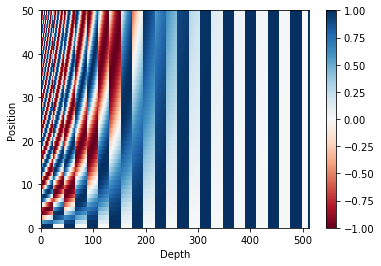

In [23]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)
#输出(1, 50, 512)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。

这确保了模型不会将填充作为输入。

该 mask 表明填充值 0 出现的位置：在这些位置 mask 输出 1，否则输出 0。

这个是官网的注释，看着就语句不顺，不看也行，代码部分有更详细的注释。

In [25]:
def create_padding_mask(seq):
    """创建padding mask，功能上来说，就是对于把序列中不是0的换成0，0换成1，1就表示被遮挡了
    Args:
        seq:输入的数据，维度是(batch_size,seq_len)
    Returns:
        处理后的结果，顺便增加了维度，变成(batch_size, 1, 1, seq_len)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]
    # 这个tf.newaxis和np.newaxis效果一样

create_padding_mask的调用示例：

In [26]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


# 前瞻遮挡（look-ahead mask）

原注释：用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [27]:
"""
关于tf.linalg.band_part函数：
这是个关于三角阵操作的函数，函数api手册说得挺花哨的，功能就是保留矩阵的非主对角线元素，其余的换成0
接收三个参数：
input: 输入的张量;
num_lower ：指定保留的主对角线下方的副对角线的数量，输入数值为负数时，
表示下方的对角矩阵元素全部保留；
num_upper：指定保留的主对角线上方的副对角线的数量，输入数值为负数时，
表示上方的对角矩阵元素全部保留；
这样解释就很清晰明了了，自己跑一跑就更清楚了
"""
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # 先产生个幺矩阵，再把主对角线上方的元素置零，变成了下三角阵，
    # 1减这个下三角阵，又变成了上三角阵（此时主对角线也全是0）
    # 在模型中的作用，后续会有解释，目前先记住代码功能就行
    return mask

In [28]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
print(temp)
# 结果是：
# tf.Tensor(
# [[0. 1. 1.]
#  [0. 0. 1.]
#  [0. 0. 0.]], shape=(3, 3), dtype=float32)

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


# 按比缩放的点积注意力（Scaled dot product attention）

原注释：Transformer 使用的注意力函数有三个输入：

Q（请求（query））、K（主键（key））、V（数值（value））。

用于计算注意力权重的等式为：

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 Q 和 K 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 dk。

因此，dk 的平方根被用于缩放（而非其他数值），因为，Q 和 K 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

In [32]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v
    虽然 mask 根据其类型（填充或前瞻）有不同的形状
    但是 mask 必须能进行广播转换以便求和

    参数:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
        output:输出
        attention_weights:注意力权重，输出权重本质上没什么用，但是可以用来可视化注意力图
    """


    matmul_qk = tf.matmul(q, k, transpose_b=True)  
    # tf.matmul，就是矩阵乘法，会自动处理好batch等维度
    # transpose_b=True就是先把右乘的矩阵转置再计算
    # 最后得到的矩阵维度就是(..., seq_len_q, seq_len_k)
    # 这一步就是计算公式里的q，k内积，不清楚的可以去官方页面查看公式
    # q，k，v什么含义一定要先看明白


    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # 用tf.shape获取的张量维度是int型的，取最后一个维度数值再转float
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # 这一步就是q、k内积再除以dk^0.5

    if mask is not None:scaled_attention_logits += (mask * -1e9) 
    # 将 mask 加入到缩放的张量上 
    # 原文没对这个做说明，我的理解是，需要屏蔽的位置(比如序列长度不足填充0的地方)，mask矩阵对应的位置就是1(可以看一下前面创建mask的两个函数)
    # 1*-1e9，那就变成很小的数字，经softmax函数后，分到的attention就很小
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数相加等于1
    # 前面的维度可以不看，最后二维就是个矩阵
    # seq_len_q行seq_len_k列，一行数据就是k的各个时间步的权重

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    # 结合q、k、v的知识，seq_len_v是等于seq_len_k的，所以这里可以乘

    return output, attention_weights

In [33]:
# 用于测试下qkv计算的函数
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)
    np.set_printoptions(suppress=True)
# 设置supress=True意味着打印出来的小数不用科学记数法

# 随机给个q、k、v瞧瞧：
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
# 实际上这里是给了query一个时间步的状态向量，所以第一个维度是1，并不影响q和k的矩阵乘法，应该都懂
print_out(temp_q, temp_k, temp_v)  
# 输出：
# Attention weights are:
# tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
# Output is:
# tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

Attention weights are:
tf.Tensor([[8.4332744e-26 1.0000000e+00 8.4332744e-26 8.4332744e-26]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[1.000000e+01 9.276602e-25]], shape=(1, 2), dtype=float32)


In [34]:
# 原文注释说了一堆，我觉得没必要看，就是换个q瞧瞧
# 不放心的可以去看看原文注释
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
# 输出：
# Attention weights are:
# tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
# Output is:
# tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [36]:
# 将所有请求一起传递
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# 多头注意力（Multi-head attention）

原注释：
多头注意力由四部分组成：

线性层并分拆成多头。
按比缩放的点积注意力。
多头及联。
最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。

将上面定义的 scaled_dot_product_attention 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用tf.transpose 和 tf.reshape），并放入最后的 Dense 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        '''
        description: 初始化类
        param {d_model:从后面的encoder部分代码看，d_model是指输入数据单个时间步的维度，或者输入数据的深度，反正就那么个意思，个人称呼不一样；
               num_heads:多头注意力的头数}
        return {None}
        '''
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        # 确保能够平均拆分到每个attention head上

        self.depth = d_model // self.num_heads
        # 刚开始我在想，有了上面的assert，这里取整除有何意义
        # 动手写了写，发现意义在于，这样得到的结果就是整数了，而直接用除法得到的是float
        # 大概这是取得int型结果的多种写法吧。。。

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        # 虽然用了全连接层，但是并没有改变数据单个时间步维度

        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        '''
        description: 输入数据拆分成多头
        param {x:就是输入数据，维度是(batch_size, seq_len, d_model)；
               batch_size:就是batch_size}
        return {经过拆分后的数据，维度是(batch_size, num_heads, seq_len, depth)}
        '''
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 别被这个depth参数名误导了，刚开始直接把他当做单个时间步状态的维度，就一直在质疑代码的正确性
        # 实际上这个depth是每个attention head的深度，在__init__里有计算过程，一不小心就忘了
        # 参数-1表示那个维度自动计算
        # 最后的维度就是(batch_size, seq_len, num_heads, depth)

        return tf.transpose(x, perm=[0, 2, 1, 3])
        # 关于这个tf.transpose函数：
        # perm参数控制转置的操作，例如transpose一个维度是2×3×4的三维张量，perm = [0,1,2]，0代表的是第一个维度，1代表第二个维度，2代表第三个维度，这样得到的就是原来的值
        # 现在令perm=[1,0,2]，表示第一个维度和第二个维度转置，得到的张量维度就是3×2×4
        # 有兴趣的可以看官方api手册

        # 于是，最终返回的数据维度就是(batch_size, num_heads, seq_len, depth)
    def call(self, v, k, q, mask):
        '''
        description: 命名为call的方法能调用父类的__call__魔法函数，反正就是tf规定子类用于计算的函数必须命名为call，就像torch必须命名为forward一样
        param {v:value；
               k:key;
               q:query;
               mask:mask张量}
        return {output:输出，就是经注意力加权后的张量;
                attention_weights:注意力权重}
        '''
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # 结合前面的scaled_dot_product_attention函数定义：
        # scaled_attention维度是(batch_size, num_heads, seq_len_q, depth)
        # attention_weights维度是(batch_size, num_heads, seq_len_q, seq_len_k)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        # reshape原理是先打平再改维度，所以这里把多头注意力拼接的操作，需要先transpose，再reshape

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

创建一个 MultiHeadAttention 层进行尝试。在序列中的每个位置 y，MultiHeadAttention 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量：

In [38]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape, attn.shape)
# 输出：(1, 60, 512) (1, 8, 60, 60)

(1, 60, 512) (1, 8, 60, 60)


# 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数：

In [39]:
# 这个太简单了，没啥好注释的
def point_wise_feed_forward_network(d_model, dff):
    # 记得这里有个dff参数，调用时都得传参，免得看到后面一头雾水还得回来翻代码
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                                ])

In [40]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


# 编码与解码（Encoder and decoder）

模型与标准的具有注意力机制的序列到序列模型（sequence to sequence with attention model），遵循相同的一般模式。

输入语句经过 N 个编码器层，为序列中的每个词/标记生成一个输出。
解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

编码器层（Encoder layer）
每个编码器层包括以下子层：

多头注意力（有填充遮挡）
点式前馈网络（Point wise feed forward networks）。
每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [42]:
# 这个注释得比较少，没啥好注释的
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        # 训练时training参数设为True，dropout生效
        # 计算时设为False，dropout就不生效了

        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # 残差
        # 其实我觉得这里虽然和残差结构一样，但并不是残差的意义，
        #而是原序列的特征向量q，加上注意力向量v
        # 不然难道只用一个注意力向量v？那也不合理

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [43]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)
# 输出：(64, 43, 512)

(64, 43, 512)


# 解码器层（Decoder layer）

每个解码器层包括以下子层：

遮挡的多头注意力（前瞻遮挡和填充遮挡）
多头注意力（用填充遮挡）。V（数值）和 K（主键）接收编码器输出作为输入。Q（请求）接收遮挡的多头注意力子层的输出。
点式前馈网络
每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

In [44]:
# 基本上一目了然
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        # 一个DecoderLayer有两个注意力，一个是真实数据的注意力
        # 一个是前一个注意力的输出相对编码器那边输出状态的注意力
        # 看一下网络结构图就能理解

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [51]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

print(sample_decoder_layer_output.shape ) # (batch_size, target_seq_len, d_model)
# 输出：TensorShape([64, 50, 512])

(64, 50, 512)


# 编码器（Encoder）

编码器 包括： 1. 输入嵌入（Input Embedding） 2. 位置编码（Positional Encoding） 3. N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [52]:
# 没太多可注释的，so easy
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        # 对第二个维度，也就是位置切片（不清楚原因的话回头翻翻positional_encoding函数及其调用示例）
        # 然后将嵌入和位置编码相加

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [53]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500,maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# 解码器（Decoder）

解码器包括： 

1. 输出嵌入（Output Embedding） 
2. 位置编码（Positional Encoding） 
3. N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [49]:
# 有难度吗？没有
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        # 用来存注意力权重的

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, 
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [54]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000, 
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, 
                              look_ahead_mask=None, 
                              padding_mask=None)

print(output.shape, attn['decoder_layer2_block2'].shape)
# 输出：(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

(64, 26, 512) (64, 8, 26, 62)


# 创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [55]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        # 最后来个全连接层用于预测，这里不加softmax
        # 其实tf最后输出是一般都不加softmax，而是损失函数里设置from_logits=True
        # 官方解释是这样误差更小

        return final_output, attention_weights

In [56]:
sample_transformer = Transformer(num_layers=2, d_model=512, 
                                 num_heads=8, dff=2048, 
                                 input_vocab_size=8500, 
                                 target_vocab_size=8000, 
                                 pe_input=10000, 
                                 pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, 
                               temp_target, 
                               training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)
# 输出：TensorShape([64, 26, 8000])

(64, 26, 8000)


# 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了num_layers、 d_model 和 dff 的值。

Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048。
关于所有其他版本的 Transformer，请查阅论文。

Note：通过改变以下数值，可以获得在许多任务上达到最先进水平的模型。

In [57]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

# 优化器（Optimizer）

根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

In [60]:
# 参照上面的公式就行，也没什么难以理解的地方
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # tf.keras.optimizers.schedules里存着各种学习率，再也不用傻傻传入float型学习率或者自己写变化学习率了，有兴趣的可以看看手册
  # 官方对tf.keras.optimizers.schedules.LearningRateSchedule的解释是A serializable learning rate decay schedule（一个可序列化的学习速率衰减时间表），可被传入各种优化器模块
  # 继承这个类，就可以把自定义的学习率类传入优化器了
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [61]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

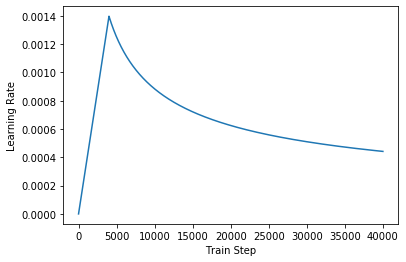

In [62]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
# 自己跑一下就会发现，这是个先上升再下降最后平缓的学习率

# 损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 等于0的地方，mask就是False，转为数字就是0了
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    # 乘上mask，序列为0的地方就不计入损失函数了

    return tf.reduce_mean(loss_)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
# 有sparse就用未经softmax的模型输出，老规矩了

# 训练与检查点（Training and checkpointing）

In [64]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [65]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    # 用于编码器的mask

    dec_padding_mask = create_padding_mask(inp)
    # 用于解码器第二个注意力模块的mask，和上面的mask一样，用不同的名字区分一下

    # 用于解码器第一个注意力模块的mask，这个mask由两个mask复合而成：
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # 1、前瞻mask，tar即目标数据，维度是batch_size × tar_seq_len × embedding_dims
    # 可以回忆下create_look_ahead_mask函数，生成一个上三角阵，维度是tar_seq_len × tar_seq_len，对角线及其以下都是0，其他的是1
    # 对于tar的一条数据来说，第i个时间步，对应前瞻mask的第i行，i及i前面的mask是0，后面的是1（表示遮挡），so easy
    dec_target_padding_mask = create_padding_mask(tar)
    # 2、填充mask
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # 用maximum函数，这样两个mask只要有一个是1的地方，combined mask对应位置就是1

    return enc_padding_mask, combined_mask, dec_padding_mask

创建检查点的路径和检查点管理器（manager）。这将用于在每 n 个周期（epochs）保存检查点：

In [66]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。tar_real 是位移了 1 的同一个输入：在 tar_inp 中的每个位置，tar_real 包含了应该被预测到的下一个标记（token）。

例如，sentence = “SOS A lion in the jungle is sleeping EOS”

tar_inp = “SOS A lion in the jungle is sleeping”

tar_real = “A lion in the jungle is sleeping EOS”

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像文本生成教程中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，自注意力（self-attention）功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [68]:
EPOCHS = 20

# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地执行。该函数专用于参数张量的精确形状。
# 为了避免由于可变序列长度或可变批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
葡萄牙语作为输入语言，英语为目标语言：

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 50 == 0:
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# 评估（Evaluate）

下面的是原注释，可以不看，直接看代码注释。
以下步骤用于评估：

用葡萄牙语分词器（tokenizer_pt）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
解码器输入为 start token == tokenizer_en.vocab_size。
计算填充遮挡和前瞻遮挡。
解码器通过查看编码器输出和它自身的输出（自注意力）给出预测。
选择最后一个词并计算它的 argmax。
将预测的词连接到解码器输入，然后传递给解码器。
在这种方法中，解码器根据它预测的之前的词预测下一个。
Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是英语的开始标记。
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
    # 预测的时候有点不一样
    # 逻辑上就是，第一轮循环，只有一个起始符，其他的0，然后取预测结果的最后一个词，和起始符拼接送入下一轮
    # 注意这里取预测结果的最后一个词，就像RNN文本生成，每一轮也是取最后一个词
    # 再取预测结果的最后一个词，和上一轮的输入拼接，送入下一轮
    # 如此循环，直到预测结果最后一个词是终止符

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
# 画图，没啥好说的，主体逻辑都在上方
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result 
                                              if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")